# Logistic Regression

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
x_train = np.array(train_dataset["train_set_x"][:]) 
y_train = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('test_catvnoncat.h5', "r")
x_test = np.array(test_dataset["test_set_x"][:]) 
y_test = np.array(test_dataset["test_set_y"][:])

In [3]:
X_train = np.reshape(x_train, (x_train.shape[0], -1))
Y_train = np.reshape(y_train,(-1,1))

X_test = np.reshape(x_test, (x_test.shape[0], -1))
Y_test = np.reshape(y_test,(-1,1))

It's not a cat!


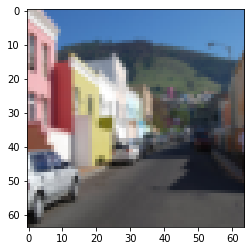

In [4]:
index = 1
plt.imshow(np.reshape(X_train[index,:], (64,64,3)))
print("It's{} a cat!".format((1-Y_train[index,0])*' not'))

It's a cat!


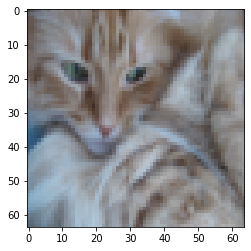

In [5]:
index = 2
plt.imshow(np.reshape(X_train[index,:], (64,64,3)))
print("It's{} a cat!".format((1-Y_train[index,0])*' not'))

In [6]:
class Layer1():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []

    def __call__(self, inputs):
        return inputs/255.
    
class Layer2():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.sigmoid(u)

In [7]:
class LossFunction():
    
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        return -tf.math.reduce_mean(y_true*tf.math.log(y_pred) + (1-y_true)*tf.math.log(1-y_pred))

In [8]:
class MetricFunction():
    
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold
                    
    def __call__(self, y_true, y_pred):
        y_pred_ = tf.sign(1+tf.sign(y_pred-self.threshold))
        return tf.math.reduce_mean(1-tf.square(tf.sign(y_true-y_pred_))) 

In [9]:
class Optimizer():
    
    def __init__(self, model, learning_rate):
        self.model = model
        self.learning_rate = learning_rate
        self.stop_training = False
        
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            weights[i].assign(w - self.learning_rate*grad_w)
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)    
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [10]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [11]:
class LogisticRegression():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
    
    def build(self):
        self.h1 = Layer1(input_dim=self.input_dim, output_dim=self.input_dim)
        self.h2 = Layer2(input_dim=self.input_dim, output_dim=self.output_dim)
        self.layers = [self.h1, self.h2]
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        a1 = self.h1(inputs)
        y = self.h2(a1) 
        return y
        
    def train_setup(self, epochs, learning_rate, threshold, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self, threshold=self.threshold)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate) 
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=500, error=0.0001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=1000, error=0.0001)]
        
    def fit(self, X, Y, epochs=1000, learning_rate=0.001, threshold=0.5, verbose=True):
        self.train_setup(epochs, learning_rate, threshold, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [12]:
logistic_regression = LogisticRegression(input_dim=X_train.shape[1], output_dim=Y_train.shape[1])

logistic_regression.fit(X_train, Y_train)

Train on 209 samples
Epochs 1/1000 - Loss: 0.6799705624580383 - Metric: 0.5885167717933655
----- 0.058s -----
Epochs 2/1000 - Loss: 0.6789956092834473 - Metric: 0.5933014154434204
----- 0.015s -----
Epochs 3/1000 - Loss: 0.6781188249588013 - Metric: 0.5980861186981201
----- 0.016s -----
Epochs 4/1000 - Loss: 0.6772805452346802 - Metric: 0.5980861186981201
----- 0.017s -----
Epochs 5/1000 - Loss: 0.676460325717926 - Metric: 0.5980861186981201
----- 0.017s -----
Epochs 6/1000 - Loss: 0.6756510138511658 - Metric: 0.5980861186981201
----- 0.019s -----
Epochs 7/1000 - Loss: 0.674849808216095 - Metric: 0.5933014154434204
----- 0.021s -----
Epochs 8/1000 - Loss: 0.6740562319755554 - Metric: 0.5980861186981201
----- 0.018s -----
Epochs 9/1000 - Loss: 0.673269510269165 - Metric: 0.5980861186981201
----- 0.019s -----
Epochs 10/1000 - Loss: 0.6724896430969238 - Metric: 0.5980861186981201
----- 0.019s -----
Epochs 11/1000 - Loss: 0.6717162728309631 - Metric: 0.5980861186981201
----- 0.015s -----
E

----- 0.015s -----
Epochs 93/1000 - Loss: 0.6226121783256531 - Metric: 0.6746411323547363
----- 0.016s -----
Epochs 94/1000 - Loss: 0.6221267580986023 - Metric: 0.6746411323547363
----- 0.014s -----
Epochs 95/1000 - Loss: 0.6216431260108948 - Metric: 0.6746411323547363
----- 0.014s -----
Epochs 96/1000 - Loss: 0.6211613416671753 - Metric: 0.6746411323547363
----- 0.014s -----
Epochs 97/1000 - Loss: 0.6206814646720886 - Metric: 0.6746411323547363
----- 0.015s -----
Epochs 98/1000 - Loss: 0.6202032566070557 - Metric: 0.6746411323547363
----- 0.014s -----
Epochs 99/1000 - Loss: 0.6197268962860107 - Metric: 0.6746411323547363
----- 0.014s -----
Epochs 100/1000 - Loss: 0.6192522048950195 - Metric: 0.6746411323547363
----- 0.014s -----
Epochs 101/1000 - Loss: 0.6187793016433716 - Metric: 0.6746411323547363
----- 0.015s -----
Epochs 102/1000 - Loss: 0.6183081865310669 - Metric: 0.6746411323547363
----- 0.015s -----
Epochs 103/1000 - Loss: 0.6178385019302368 - Metric: 0.6746411323547363
----- 

Epochs 183/1000 - Loss: 0.5847042202949524 - Metric: 0.6937798857688904
----- 0.015s -----
Epochs 184/1000 - Loss: 0.5843355059623718 - Metric: 0.6937798857688904
----- 0.014s -----
Epochs 185/1000 - Loss: 0.5839676856994629 - Metric: 0.6937798857688904
----- 0.014s -----
Epochs 186/1000 - Loss: 0.5836006999015808 - Metric: 0.6937798857688904
----- 0.015s -----
Epochs 187/1000 - Loss: 0.5832347869873047 - Metric: 0.6937798857688904
----- 0.015s -----
Epochs 188/1000 - Loss: 0.5828697085380554 - Metric: 0.6937798857688904
----- 0.015s -----
Epochs 189/1000 - Loss: 0.5825056433677673 - Metric: 0.6937798857688904
----- 0.015s -----
Epochs 190/1000 - Loss: 0.5821424126625061 - Metric: 0.6937798857688904
----- 0.015s -----
Epochs 191/1000 - Loss: 0.5817800760269165 - Metric: 0.6937798857688904
----- 0.015s -----
Epochs 192/1000 - Loss: 0.5814186930656433 - Metric: 0.6937798857688904
----- 0.016s -----
Epochs 193/1000 - Loss: 0.581058144569397 - Metric: 0.6937798857688904
----- 0.022s -----


----- 0.015s -----
Epochs 274/1000 - Loss: 0.5544705390930176 - Metric: 0.7129186391830444
----- 0.02s -----
Epochs 275/1000 - Loss: 0.5541707277297974 - Metric: 0.7129186391830444
----- 0.014s -----
Epochs 276/1000 - Loss: 0.5538715124130249 - Metric: 0.7129186391830444
----- 0.015s -----
Epochs 277/1000 - Loss: 0.5535728931427002 - Metric: 0.7129186391830444
----- 0.014s -----
Epochs 278/1000 - Loss: 0.553274929523468 - Metric: 0.7129186391830444
----- 0.015s -----
Epochs 279/1000 - Loss: 0.5529775023460388 - Metric: 0.7129186391830444
----- 0.016s -----
Epochs 280/1000 - Loss: 0.5526807308197021 - Metric: 0.7129186391830444
----- 0.014s -----
Epochs 281/1000 - Loss: 0.5523845553398132 - Metric: 0.7129186391830444
----- 0.016s -----
Epochs 282/1000 - Loss: 0.5520889163017273 - Metric: 0.7129186391830444
----- 0.018s -----
Epochs 283/1000 - Loss: 0.5517940521240234 - Metric: 0.7129186391830444
----- 0.014s -----
Epochs 284/1000 - Loss: 0.551499605178833 - Metric: 0.7129186391830444
--

----- 0.015s -----
Epochs 365/1000 - Loss: 0.5294314026832581 - Metric: 0.7224880456924438
----- 0.017s -----
Epochs 366/1000 - Loss: 0.5291789174079895 - Metric: 0.7272727489471436
----- 0.016s -----
Epochs 367/1000 - Loss: 0.5289267301559448 - Metric: 0.7272727489471436
----- 0.016s -----
Epochs 368/1000 - Loss: 0.5286749005317688 - Metric: 0.7272727489471436
----- 0.015s -----
Epochs 369/1000 - Loss: 0.5284236073493958 - Metric: 0.7272727489471436
----- 0.014s -----
Epochs 370/1000 - Loss: 0.5281727910041809 - Metric: 0.7320573925971985
----- 0.014s -----
Epochs 371/1000 - Loss: 0.5279222726821899 - Metric: 0.7320573925971985
----- 0.015s -----
Epochs 372/1000 - Loss: 0.5276721715927124 - Metric: 0.7320573925971985
----- 0.014s -----
Epochs 373/1000 - Loss: 0.5274225473403931 - Metric: 0.7320573925971985
----- 0.014s -----
Epochs 374/1000 - Loss: 0.5271733999252319 - Metric: 0.7320573925971985
----- 0.014s -----
Epochs 375/1000 - Loss: 0.5269246697425842 - Metric: 0.7320573925971985

Epochs 455/1000 - Loss: 0.5082837343215942 - Metric: 0.7416267991065979
----- 0.014s -----
Epochs 456/1000 - Loss: 0.5080651044845581 - Metric: 0.7416267991065979
----- 0.013s -----
Epochs 457/1000 - Loss: 0.5078468322753906 - Metric: 0.7416267991065979
----- 0.014s -----
Epochs 458/1000 - Loss: 0.5076289772987366 - Metric: 0.7416267991065979
----- 0.015s -----
Epochs 459/1000 - Loss: 0.5074113011360168 - Metric: 0.7464115023612976
----- 0.015s -----
Epochs 460/1000 - Loss: 0.5071939826011658 - Metric: 0.7464115023612976
----- 0.015s -----
Epochs 461/1000 - Loss: 0.5069770216941833 - Metric: 0.7464115023612976
----- 0.015s -----
Epochs 462/1000 - Loss: 0.5067603588104248 - Metric: 0.7464115023612976
----- 0.015s -----
Epochs 463/1000 - Loss: 0.5065439939498901 - Metric: 0.7464115023612976
----- 0.015s -----
Epochs 464/1000 - Loss: 0.5063280463218689 - Metric: 0.7464115023612976
----- 0.015s -----
Epochs 465/1000 - Loss: 0.5061123371124268 - Metric: 0.7464115023612976
----- 0.015s -----

----- 0.015s -----
Epochs 546/1000 - Loss: 0.4896177351474762 - Metric: 0.760765552520752
----- 0.017s -----
Epochs 547/1000 - Loss: 0.48942530155181885 - Metric: 0.760765552520752
----- 0.014s -----
Epochs 548/1000 - Loss: 0.48923298716545105 - Metric: 0.760765552520752
----- 0.017s -----
Epochs 549/1000 - Loss: 0.4890410006046295 - Metric: 0.760765552520752
----- 0.014s -----
Epochs 550/1000 - Loss: 0.4888492524623871 - Metric: 0.760765552520752
----- 0.014s -----
Epochs 551/1000 - Loss: 0.48865774273872375 - Metric: 0.760765552520752
----- 0.015s -----
Epochs 552/1000 - Loss: 0.48846644163131714 - Metric: 0.760765552520752
----- 0.015s -----
Epochs 553/1000 - Loss: 0.48827555775642395 - Metric: 0.760765552520752
----- 0.014s -----
Epochs 554/1000 - Loss: 0.48808473348617554 - Metric: 0.760765552520752
----- 0.015s -----
Epochs 555/1000 - Loss: 0.48789429664611816 - Metric: 0.760765552520752
----- 0.016s -----
Epochs 556/1000 - Loss: 0.48770397901535034 - Metric: 0.760765552520752
--

----- 0.017s -----
Epochs 636/1000 - Loss: 0.4732251465320587 - Metric: 0.7703348994255066
----- 0.017s -----
Epochs 637/1000 - Loss: 0.47305282950401306 - Metric: 0.7703348994255066
----- 0.016s -----
Epochs 638/1000 - Loss: 0.47288063168525696 - Metric: 0.7703348994255066
----- 0.017s -----
Epochs 639/1000 - Loss: 0.47270867228507996 - Metric: 0.7703348994255066
----- 0.016s -----
Epochs 640/1000 - Loss: 0.47253698110580444 - Metric: 0.7703348994255066
----- 0.015s -----
Epochs 641/1000 - Loss: 0.47236546874046326 - Metric: 0.7703348994255066
----- 0.016s -----
Epochs 642/1000 - Loss: 0.4721940755844116 - Metric: 0.7703348994255066
----- 0.016s -----
Epochs 643/1000 - Loss: 0.47202298045158386 - Metric: 0.7703348994255066
----- 0.016s -----
Epochs 644/1000 - Loss: 0.47185197472572327 - Metric: 0.7703348994255066
----- 0.016s -----
Epochs 645/1000 - Loss: 0.4716812074184418 - Metric: 0.7703348994255066
----- 0.017s -----
Epochs 646/1000 - Loss: 0.4715106785297394 - Metric: 0.770334899

----- 0.016s -----
Epochs 726/1000 - Loss: 0.4584607481956482 - Metric: 0.7846890091896057
----- 0.017s -----
Epochs 727/1000 - Loss: 0.45830464363098145 - Metric: 0.7846890091896057
----- 0.015s -----
Epochs 728/1000 - Loss: 0.45814868807792664 - Metric: 0.7846890091896057
----- 0.016s -----
Epochs 729/1000 - Loss: 0.4579928517341614 - Metric: 0.7846890091896057
----- 0.016s -----
Epochs 730/1000 - Loss: 0.45783719420433044 - Metric: 0.7846890091896057
----- 0.015s -----
Epochs 731/1000 - Loss: 0.45768168568611145 - Metric: 0.7846890091896057
----- 0.015s -----
Epochs 732/1000 - Loss: 0.45752638578414917 - Metric: 0.779904305934906
----- 0.014s -----
Epochs 733/1000 - Loss: 0.45737120509147644 - Metric: 0.779904305934906
----- 0.015s -----
Epochs 734/1000 - Loss: 0.45721620321273804 - Metric: 0.779904305934906
----- 0.015s -----
Epochs 735/1000 - Loss: 0.4570612907409668 - Metric: 0.779904305934906
----- 0.015s -----
Epochs 736/1000 - Loss: 0.45690658688545227 - Metric: 0.779904305934

----- 0.015s -----
Epochs 817/1000 - Loss: 0.4448760151863098 - Metric: 0.7942583560943604
----- 0.016s -----
Epochs 818/1000 - Loss: 0.44473332166671753 - Metric: 0.7942583560943604
----- 0.016s -----
Epochs 819/1000 - Loss: 0.4445907473564148 - Metric: 0.7942583560943604
----- 0.014s -----
Epochs 820/1000 - Loss: 0.4444482624530792 - Metric: 0.7942583560943604
----- 0.014s -----
Epochs 821/1000 - Loss: 0.44430601596832275 - Metric: 0.7942583560943604
----- 0.014s -----
Epochs 822/1000 - Loss: 0.44416382908821106 - Metric: 0.7942583560943604
----- 0.015s -----
Epochs 823/1000 - Loss: 0.4440218210220337 - Metric: 0.7942583560943604
----- 0.015s -----
Epochs 824/1000 - Loss: 0.4438798427581787 - Metric: 0.7942583560943604
----- 0.015s -----
Epochs 825/1000 - Loss: 0.4437381327152252 - Metric: 0.7942583560943604
----- 0.016s -----
Epochs 826/1000 - Loss: 0.4435965120792389 - Metric: 0.7942583560943604
----- 0.016s -----
Epochs 827/1000 - Loss: 0.4434550404548645 - Metric: 0.7942583560943

----- 0.015s -----
Epochs 907/1000 - Loss: 0.43254217505455017 - Metric: 0.8086124658584595
----- 0.015s -----
Epochs 908/1000 - Loss: 0.4324105978012085 - Metric: 0.8086124658584595
----- 0.015s -----
Epochs 909/1000 - Loss: 0.43227916955947876 - Metric: 0.8086124658584595
----- 0.015s -----
Epochs 910/1000 - Loss: 0.4321478009223938 - Metric: 0.8086124658584595
----- 0.016s -----
Epochs 911/1000 - Loss: 0.4320165812969208 - Metric: 0.8086124658584595
----- 0.017s -----
Epochs 912/1000 - Loss: 0.43188542127609253 - Metric: 0.8086124658584595
----- 0.018s -----
Epochs 913/1000 - Loss: 0.431754469871521 - Metric: 0.8086124658584595
----- 0.015s -----
Epochs 914/1000 - Loss: 0.43162354826927185 - Metric: 0.8086124658584595
----- 0.015s -----
Epochs 915/1000 - Loss: 0.43149274587631226 - Metric: 0.8086124658584595
----- 0.016s -----
Epochs 916/1000 - Loss: 0.4313620924949646 - Metric: 0.8086124658584595
----- 0.017s -----
Epochs 917/1000 - Loss: 0.4312315285205841 - Metric: 0.808612465858

----- 0.016s -----
Epochs 997/1000 - Loss: 0.4211336672306061 - Metric: 0.8325358629226685
----- 0.016s -----
Epochs 998/1000 - Loss: 0.4210115373134613 - Metric: 0.8325358629226685
----- 0.017s -----
Epochs 999/1000 - Loss: 0.42088955640792847 - Metric: 0.8325358629226685
----- 0.016s -----
Epochs 1000/1000 - Loss: 0.420767605304718 - Metric: 0.8325358629226685
----- 0.016s -----


In [13]:
logistic_regression.evaluate(X_test, Y_test)

Loss: 0.7116547226905823 - Metric: 0.5400000214576721


[0.7116547, 0.54]

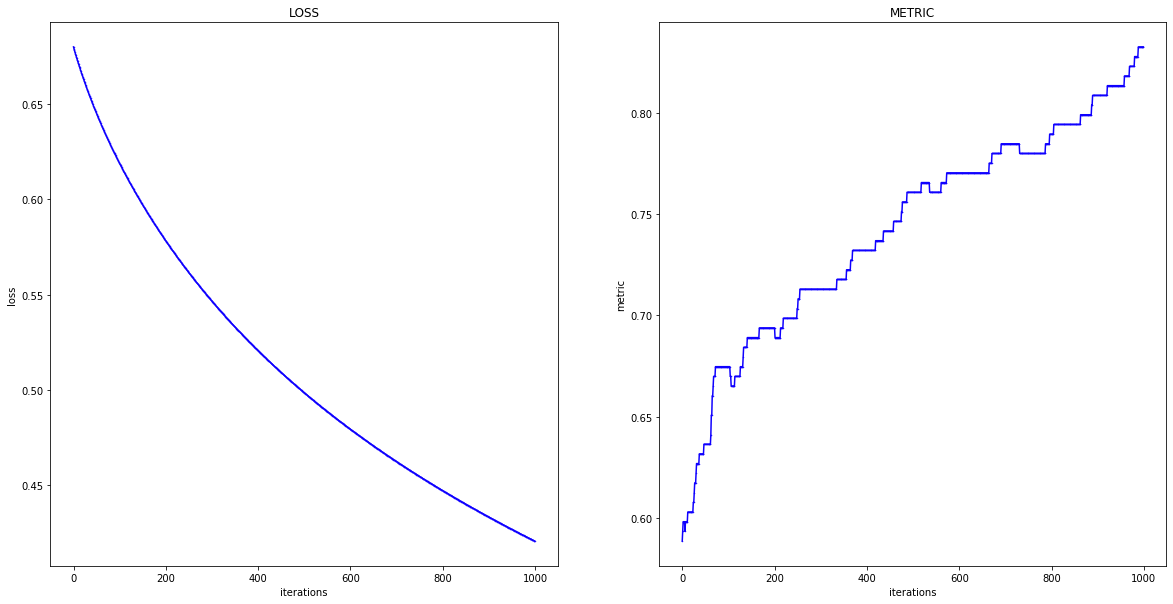

In [14]:
loss = logistic_regression.history['loss']
metric = logistic_regression.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')

It's not a cat!


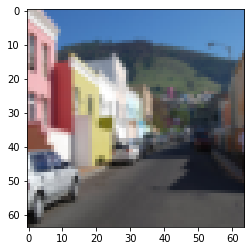

In [15]:
index = 1
plt.imshow(np.reshape(X_train[index,:], (64,64,3)))
print("It's{} a cat!".format((1-(logistic_regression.predict(X_train[[index],:])[0,0]>0.5).astype(int))*' not'))

It's a cat!


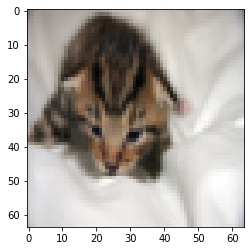

In [16]:
index = 1
plt.imshow(np.reshape(X_test[index,:], (64,64,3)))
print("It's{} a cat!".format((1-(logistic_regression.predict(X_test[[index],:])[0,0]>0.5).astype(int))*' not'))